In [1]:
import torch 
from torch import nn

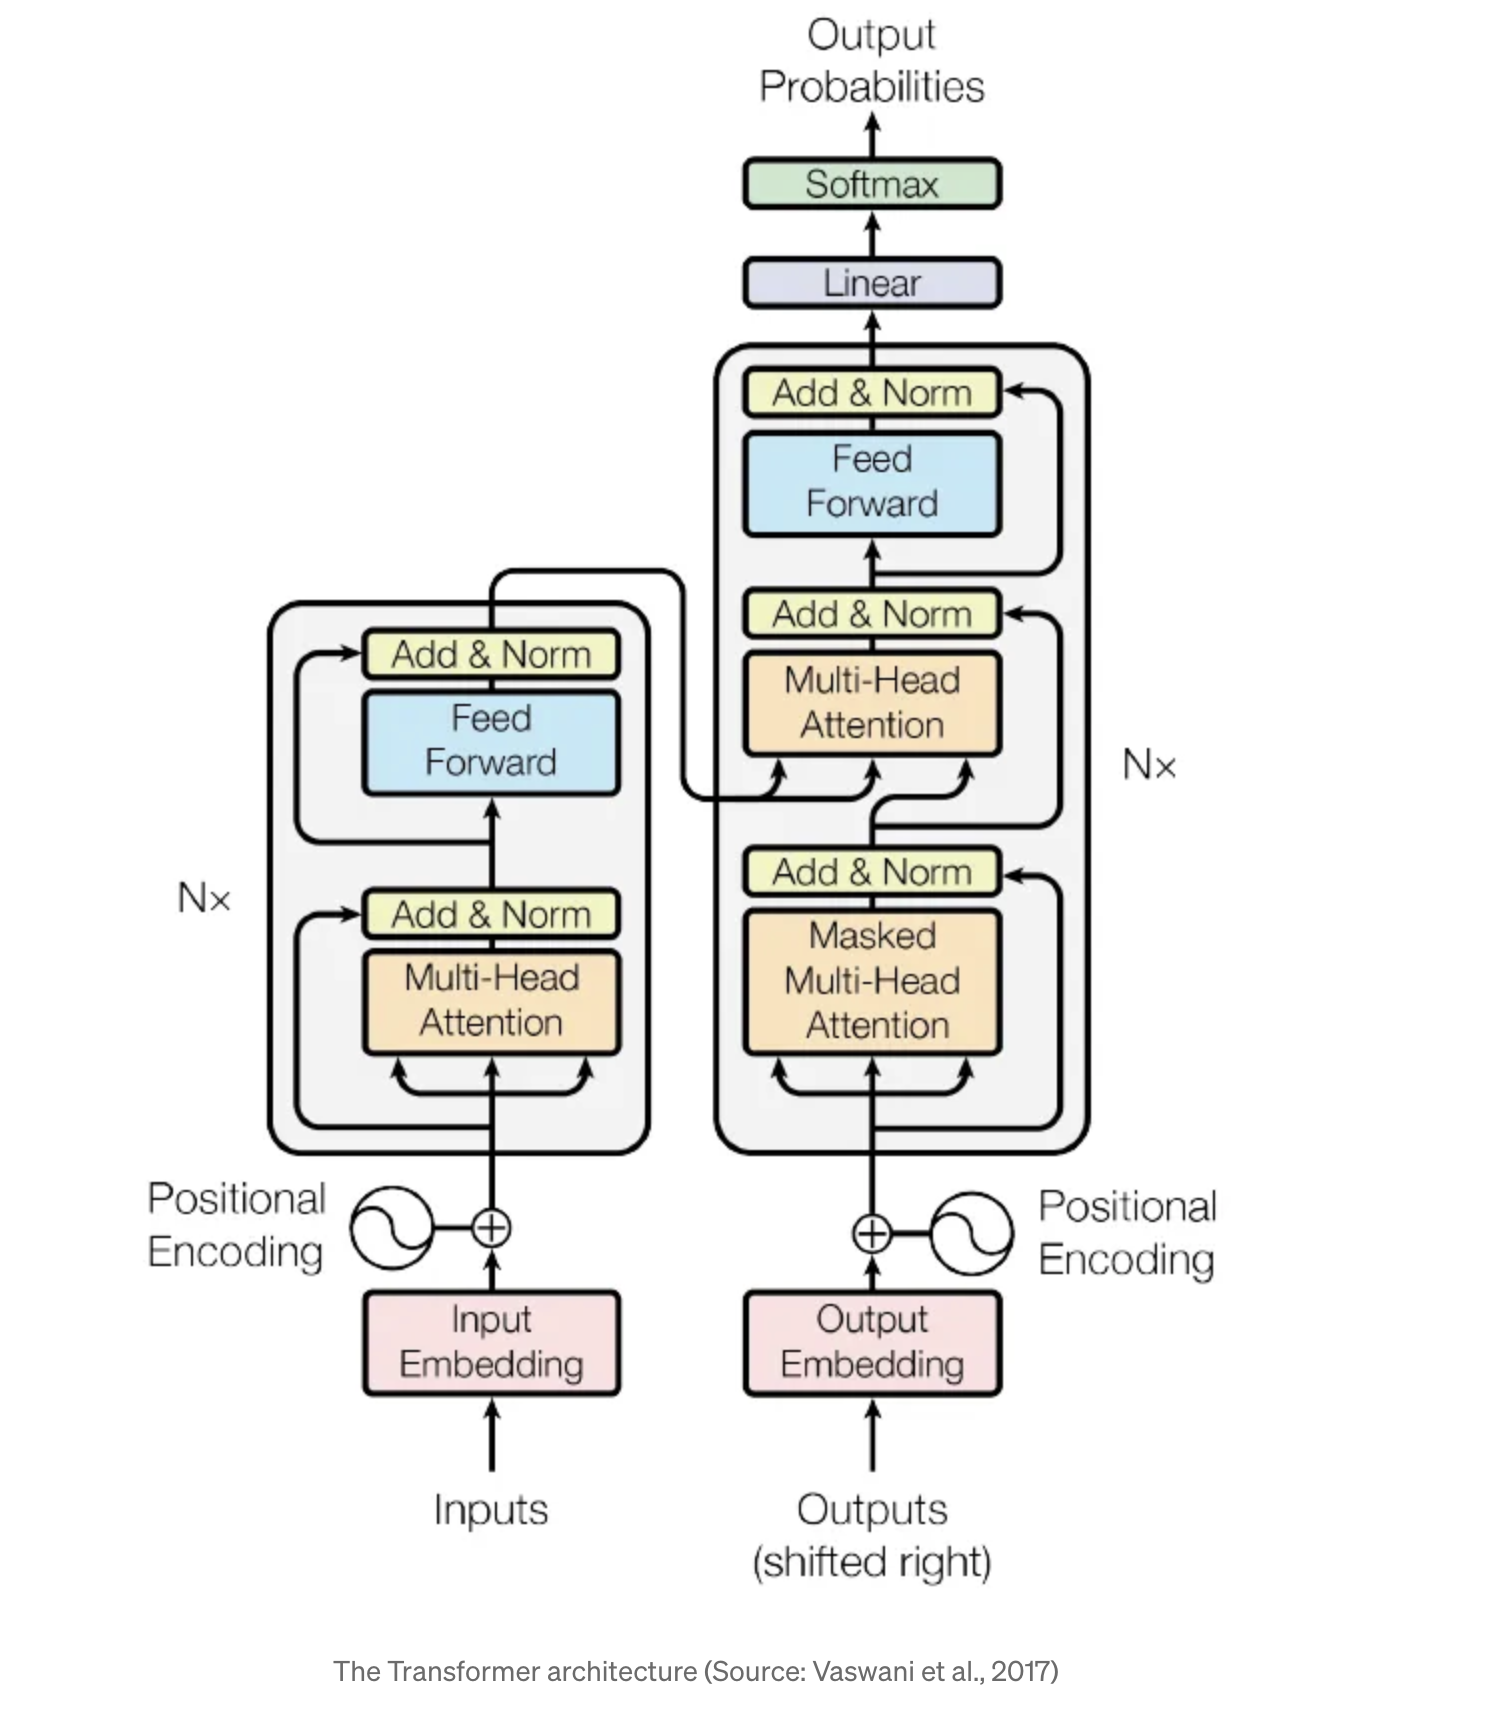

In [2]:
config = {
    'num_tokens' : 75000 ,
    'max_len' : 512 , 
    'embedding_dim' : 768 , 
    'inter_dim' : 768*4 , 
    'head_dim' : 64 , 
    'num_heads' : 768//64 , 
    'dropout_prob' : 0.2
}    

In [55]:
class EmbeddingLayer(nn.Module):
    def __init__(self , config):
            
        """ A class that is used to encode inputs/words into tensors which is later fed into Encoder/Decoder layers.
        Contains 4 main steps in the forward method
        1. Token Embeddings - Embedddings for tokens
        2. Positional Embeddings - Embeddings for positions 
        3. LayerNorm - Normalizing agent
        4. Dropout - A commonly used regulrization method in NN
        """
        super(EmbeddingLayer, self).__init__()
    
        self.input_embeddings = nn.Embedding(config['num_tokens'] , config['embedding_dim'])
        self.pos_embeddings = nn.Embedding(config['max_len'] , config['embedding_dim'])

        self.layer_norm = nn.LayerNorm(config['embedding_dim'])
        self.dropout = nn.Dropout(config['dropout_prob'])

    def forward(self , x):
        inputs = self.input_embeddings(x)
        pos = self.pos_embeddings(torch.arange(x.size(1)))

        out = inputs + pos
        out = self.layer_norm(out)
        out = self.dropout(out)
        
        return out



In [56]:
input_embeddings = EmbeddingLayer(config)

x = torch.tensor([[1,2,3,6,8],
           [5,2,3,6,8],
           [4,2,3,6,8]])

input_embeddings(x).shape        

torch.Size([3, 5, 768])

In [57]:

import math
import torch.nn.functional as F


def scalar_dot_product(q,k,v,mask = None):
    """ Accepts 3 args namely :     
        1. q - Query 
        2. k - Key 
        3. v - Value 
    
        All these three components are generated by passing the input IDs through 3 independent Neural Networks .
        Output is generated using the following formula out = softmax(Q @ K.T) @ V
    """
    
    # shape q : batch (b) , sequence_len (s) , embedding_dim (d)
    embeddding_dim = q.size(-1)
    out = torch.bmm(q , k.transpose(1,2)) / math.sqrt(embeddding_dim) # (b,s,d) @ (b,d,s) = (b,s,s)
    logits = F.softmax(out , dim = -1) # (b,s,s)
    if mask :
        seq_len = logits.size(1)
        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
        logits.masked_fill(mask==0,value = -float('inf'))
        
    out = torch.bmm(logits , v ) # (b,s,s) @ (b,s,d) = (b,s,d)
    return out   # (b,s,d)

class SingleHeadAttention(nn.Module):
    """ Splits the inputs into query , key and value and then performs scalar dot product to get the output for the same 
    """
    def __init__(self,head_dim,embedding_dim,masked = None):
        super(SingleHeadAttention, self).__init__()
        self.masked = masked
        self.linear_q = nn.Linear(embedding_dim , head_dim)
        self.linear_k = nn.Linear(embedding_dim , head_dim)
        self.linear_v = nn.Linear(embedding_dim , head_dim)
        
    def forward(self,x):
        q = self.linear_q(x)
        k = self.linear_k(x)
        v = self.linear_v(x)

        out = scalar_dot_product(q,k,v,self.masked)
        return out

class MultiHeadAttention(nn.Module):
    """ Creates n_head Attention Heads , concats the outputs , runs them into a linear NN to get the output
    Analgolus to CausalSelfAttention in miniGPT written by Andrej Karpathy :
    https://github.com/karpathy/minGPT/blob/7218bcfa527c65f164de791099de715b81a95106/mingpt/model.py
    """
    def __init__(self,embedding_dim,head_dim,masked = None):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = embedding_dim // head_dim 
        self.attention_layers = nn.ModuleList([SingleHeadAttention(head_dim,embedding_dim,masked) for _ in range(self.num_heads)])
        self.linear = nn.Linear(embedding_dim,embedding_dim)
    
    def forward(self,x):
        x = torch.cat([layer(x) for layer in self.attention_layers] , -1)
        out = self.linear(x)
        return out

class FeedForward(nn.Module):
    """ Feed Forward layer is mainly introduced to understand and better interpret the attention weights derived in the previous module .
    Contains two linear layers with dropout layer in the end and Gausian error linear units (https://arxiv.org/abs/1606.08415)
    """
    def __init__(self,embedding_dim,inter_dim):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(embedding_dim,inter_dim)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(inter_dim,embedding_dim)
        self.dropout = nn.Dropout()
    
    def forward(self,x):
        x = self.gelu(self.linear1(x))
        x = self.dropout(self.linear2(x))
        return x

class TransformerBlock(nn.Module):
    """ Contains the Building Block combines the following items :
    1. LayerNorm1
    2. MultiAttention
    3. LayerNorm2
    4. FeedForward
    """
    def __init__(self,config):
        super(TransformerBlock, self).__init__()
        embedding_dim,head_dim,inter_dim = config['embedding_dim'],config['head_dim'],config['inter_dim']
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.multi_head_attention = MultiHeadAttention(embedding_dim,head_dim,config.get('masked',None))
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.ff = FeedForward(embedding_dim,inter_dim)
    def forward(self,x):
        x = self.multi_head_attention(self.layer_norm1(x)) + x
        x = self.ff(self.layer_norm2(x)) + x
        return x

class Transformer(nn.Module):
    def __init__(self,config):
        super(Transformer, self).__init__()
        
        embedding_dim = config['embedding_dim']
        head_dim = config['head_dim']
        inter_dim = config['inter_dim']
 
        self.embedding_layer = EmbeddingLayer(config)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(config) for _ in range(config['num_blocks'])])
    
    def forward(self,x):
        x = self.embedding_layer(x)
        
        for block in self.transformer_blocks:
            x = block(x)
        return x




In [4]:
import torch
seq_len = 5
torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)

tensor([[[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]])

In [58]:
config = {
    'num_tokens' : 75000 ,
    'max_len' : 512 , 
    'embedding_dim' : 768 , 
    'inter_dim' : 768*4 , 
    'head_dim' : 64 , 
    'num_heads' : 768//64 , 
    'dropout_prob' : 0.2 , 
    'num_blocks' : 5 , 
    'masked' : True
}    
config.get('masked',None)

True

In [62]:
transformer = Transformer(config)

x = torch.tensor([[1,2,3,6,8],
           [5,2,3,6,8],
           [4,2,3,6,8]])


transformer(x).shape

torch.Size([3, 5, 768])

## Create Datasets